In [ ]:
!pip install obspy

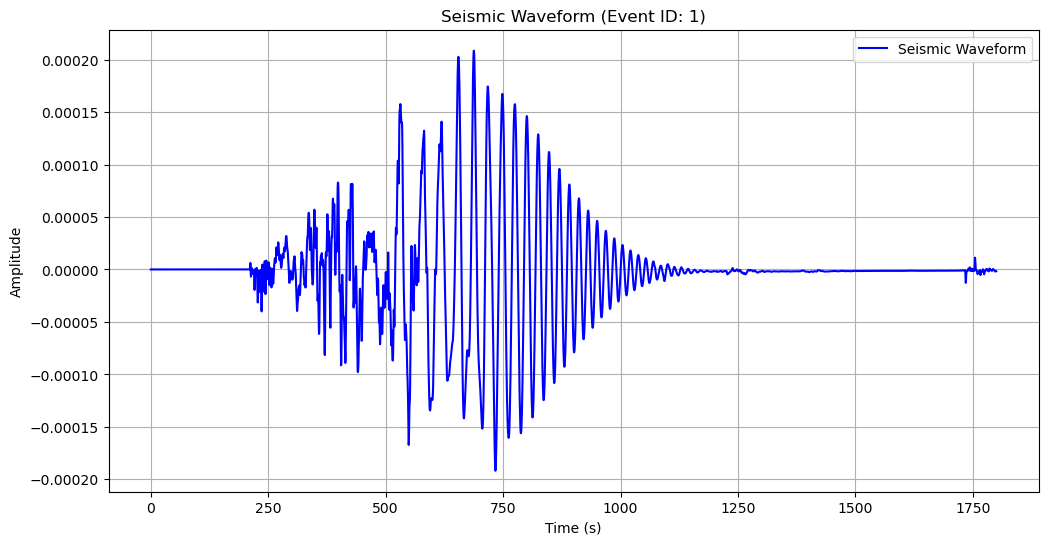

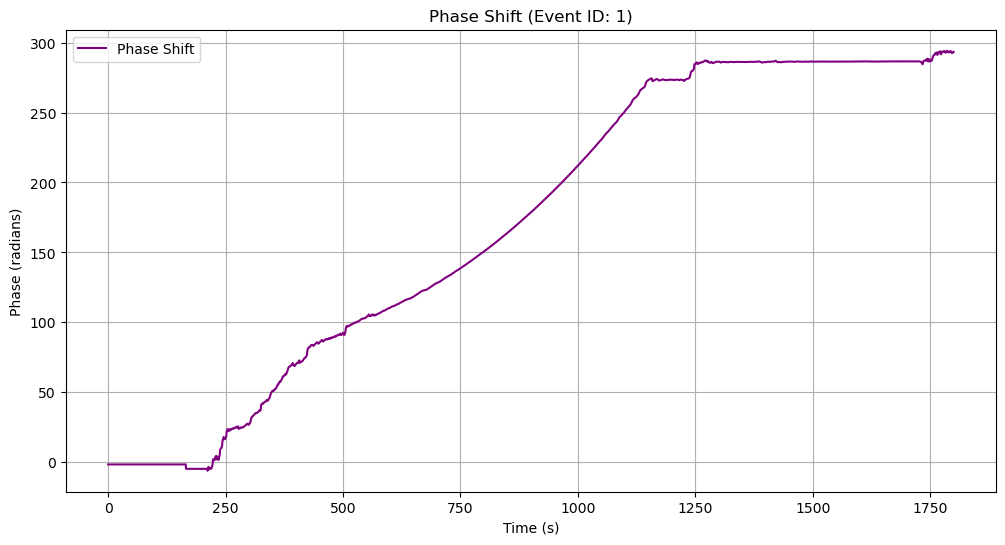

Extracted Features for Event ID 1:
- Max Amplitude: 0.0002084259467665106
- RMS Amplitude: 4.829421959584579e-05
- Dominant Frequency (Hz): 0.03721229894250422


In [3]:
import numpy as np
from obspy.clients.syngine import Client
from obspy import UTCDateTime
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# Initialize Syngine Client
client = Client()

def generate_waveform_and_features(
    source_latitude, source_longitude, source_depth_km,
    receiver_latitude, receiver_longitude, mars_model="mars_insightkks21gp_2s", duration=1800.0):
    """
    Generate seismic waveform using Syngine and extract amplitude, frequency, and phase shift features.

    Parameters:
    - source_latitude: Latitude of the seismic event source.
    - source_longitude: Longitude of the seismic event source.
    - source_depth_km: Depth of the seismic event source in kilometers.
    - receiver_latitude: Latitude of the receiver.
    - receiver_longitude: Longitude of the receiver.
    - mars_model: Mars seismic model to use for Syngine.
    - duration: Duration of the waveform in seconds.

    Returns:
    - Dictionary containing waveform, features, and metadata.
    """
    try:
        # Request waveform from Syngine
        st = client.get_waveforms(
            model=mars_model,
            sourcelatitude=source_latitude,
            sourcelongitude=source_longitude,
            sourcedepthinmeters=source_depth_km * 1000,  # Convert km to meters
            receiverlatitude=receiver_latitude,
            receiverlongitude=receiver_longitude,
            components="Z",
            units="displacement",
            origintime=UTCDateTime("2025-01-01T00:00:00"),
            starttime=0.0,
            endtime=duration
        )

        # Extract waveform data and sampling rate
        tr = st[0]  # Use the first trace
        waveform = tr.data  # Raw waveform data
        sampling_rate = tr.stats.sampling_rate  # Sampling rate in Hz
        dt = tr.stats.delta  # Sampling interval (1 / sampling_rate)

        # Compute amplitude features
        max_amplitude = np.max(np.abs(waveform))
        rms_amplitude = np.sqrt(np.mean(waveform**2))

        # Compute dominant frequency using FFT
        freqs = np.fft.rfftfreq(len(waveform), dt)
        fft_spectrum = np.abs(np.fft.rfft(waveform))
        dominant_frequency = freqs[np.argmax(fft_spectrum)]

        # Compute phase shift using Hilbert transform
        analytic_signal = hilbert(waveform)
        phase_shift = np.unwrap(np.angle(analytic_signal))

        # Return results
        return {
            "Waveform": waveform,
            "Sampling Rate": sampling_rate,
            "Max Amplitude": max_amplitude,
            "RMS Amplitude": rms_amplitude,
            "Dominant Frequency (Hz)": dominant_frequency,
            "Phase Shift": phase_shift,
            "Time Array": np.arange(0, len(waveform) * dt, dt)[:len(phase_shift)]  # Time array for plotting
        }

    except Exception as e:
        print(f"Error generating waveform: {e}")
        return None


def visualize_waveform_and_features(features, event_id=1):
    """
    Visualize the seismic waveform, phase shift, and extracted features.

    Parameters:
    - features: Dictionary containing waveform, features, and metadata.
    - event_id: ID of the seismic event (for labeling purposes).
    """
    waveform = features["Waveform"]
    time_array = features["Time Array"]

    # Plot the waveform
    plt.figure(figsize=(12, 6))
    plt.plot(time_array, waveform, label="Seismic Waveform", color="blue")
    plt.title(f"Seismic Waveform (Event ID: {event_id})")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot the phase shift
    plt.figure(figsize=(12, 6))
    plt.plot(time_array, features["Phase Shift"], label="Phase Shift", color="purple")
    plt.title(f"Phase Shift (Event ID: {event_id})")
    plt.xlabel("Time (s)")
    plt.ylabel("Phase (radians)")
    plt.legend()
    plt.grid()
    plt.show()

    # Display extracted features
    print(f"Extracted Features for Event ID {event_id}:")
    print(f"- Max Amplitude: {features['Max Amplitude']}")
    print(f"- RMS Amplitude: {features['RMS Amplitude']}")
    print(f"- Dominant Frequency (Hz): {features['Dominant Frequency (Hz)']}")


# Example Usage
if __name__ == "__main__":
    # Define seismic event and receiver locations
    source_latitude = 10.0
    source_longitude = 20.0
    source_depth_km = 50.0
    receiver_latitude = 30.0
    receiver_longitude = 40.0

    # Generate waveform and extract features
    features = generate_waveform_and_features(
        source_latitude=source_latitude,
        source_longitude=source_longitude,
        source_depth_km=source_depth_km,
        receiver_latitude=receiver_latitude,
        receiver_longitude=receiver_longitude
    )

    # Visualize waveform and features
    if features:
        visualize_waveform_and_features(features, event_id=1)


# Precpocess the waveform with baseline correction, bandpass filtering and normalization

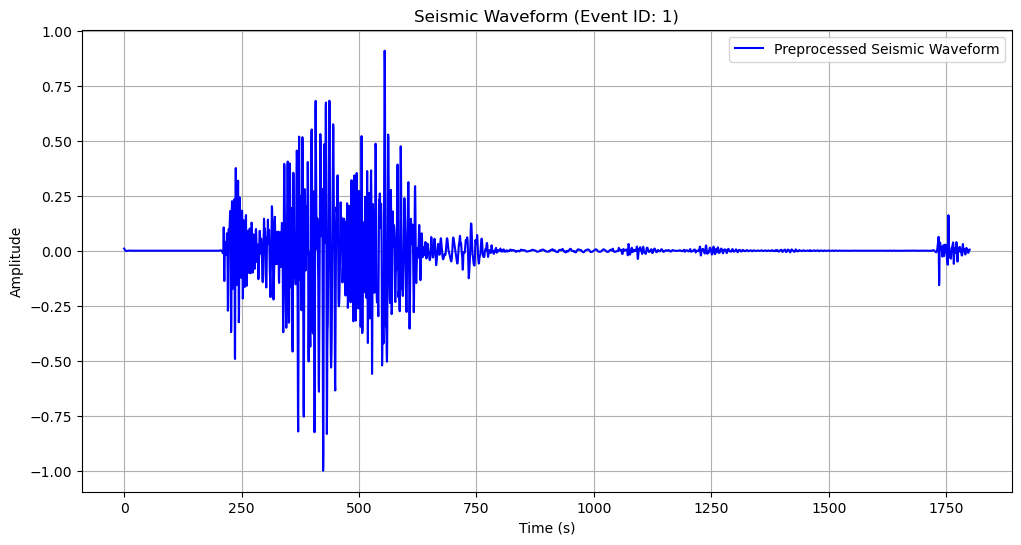

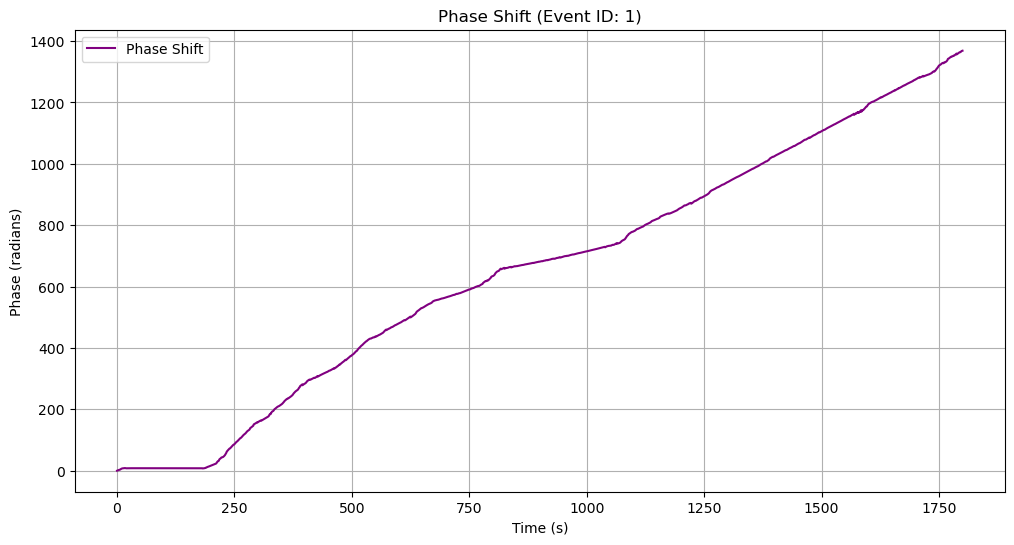

Extracted Features for Event ID 1:
- Max Amplitude: 1.0
- RMS Amplitude: 0.11958916221004748
- Dominant Frequency (Hz): 0.10941526703990047


In [4]:
import numpy as np
from obspy.clients.syngine import Client
from obspy import UTCDateTime
from obspy.signal.filter import bandpass
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Initialize Syngine Client
client = Client()

def preprocess_waveform(waveform, sampling_rate, bandpass_freq=(0.1, 20.0)):
    """
    Preprocess the seismic waveform by applying baseline correction, noise filtering, and normalization.

    Parameters:
    - waveform: 1D numpy array of the seismic waveform.
    - sampling_rate: Sampling rate of the waveform in Hz.
    - bandpass_freq: Tuple specifying the low and high cutoff frequencies for bandpass filtering.

    Returns:
    - Preprocessed waveform.
    """
    # Baseline Correction (Remove DC Offset)
    waveform = waveform - np.mean(waveform)

    # Bandpass Filtering (Remove high and low frequency noise)
    waveform = bandpass(waveform, bandpass_freq[0], bandpass_freq[1], sampling_rate, corners=4, zerophase=True)

    # Normalization (Scale waveform to [-1, 1])
    waveform = waveform / np.max(np.abs(waveform))

    return waveform


def generate_waveform_and_features(
    source_latitude, source_longitude, source_depth_km,
    receiver_latitude, receiver_longitude, mars_model="mars_insightkks21gp_2s", duration=1800.0, bandpass_freq=(0.1, 20.0)):
    """
    Generate seismic waveform using Syngine, preprocess it, and extract amplitude, frequency, and phase shift features.

    Parameters:
    - source_latitude: Latitude of the seismic event source.
    - source_longitude: Longitude of the seismic event source.
    - source_depth_km: Depth of the seismic event source in kilometers.
    - receiver_latitude: Latitude of the receiver.
    - receiver_longitude: Longitude of the receiver.
    - mars_model: Mars seismic model to use for Syngine.
    - duration: Duration of the waveform in seconds.
    - bandpass_freq: Tuple specifying the low and high cutoff frequencies for bandpass filtering.

    Returns:
    - Dictionary containing waveform, features, and metadata.
    """
    try:
        # Request waveform from Syngine
        st = client.get_waveforms(
            model=mars_model,
            sourcelatitude=source_latitude,
            sourcelongitude=source_longitude,
            sourcedepthinmeters=source_depth_km * 1000,  # Convert km to meters
            receiverlatitude=receiver_latitude,
            receiverlongitude=receiver_longitude,
            components="Z",
            units="displacement",
            origintime=UTCDateTime("2025-01-01T00:00:00"),
            starttime=0.0,
            endtime=duration
        )

        # Extract waveform data and sampling rate
        tr = st[0]  # Use the first trace
        waveform = tr.data  # Raw waveform data
        sampling_rate = tr.stats.sampling_rate  # Sampling rate in Hz
        dt = tr.stats.delta  # Sampling interval (1 / sampling_rate)

        # Preprocess the waveform
        waveform = preprocess_waveform(waveform, sampling_rate, bandpass_freq)

        # Compute amplitude features
        max_amplitude = np.max(np.abs(waveform))
        rms_amplitude = np.sqrt(np.mean(waveform**2))

        # Compute dominant frequency using FFT
        freqs = np.fft.rfftfreq(len(waveform), dt)
        fft_spectrum = np.abs(np.fft.rfft(waveform))
        dominant_frequency = freqs[np.argmax(fft_spectrum)]

        # Compute phase shift using Hilbert transform
        analytic_signal = hilbert(waveform)
        phase_shift = np.unwrap(np.angle(analytic_signal))

        # Return results
        return {
            "Waveform": waveform,
            "Sampling Rate": sampling_rate,
            "Max Amplitude": max_amplitude,
            "RMS Amplitude": rms_amplitude,
            "Dominant Frequency (Hz)": dominant_frequency,
            "Phase Shift": phase_shift,
            "Time Array": np.arange(0, len(waveform) * dt, dt)[:len(phase_shift)]  # Time array for plotting
        }

    except Exception as e:
        print(f"Error generating waveform: {e}")
        return None


def visualize_waveform_and_features(features, event_id=1):
    """
    Visualize the seismic waveform, phase shift, and extracted features.

    Parameters:
    - features: Dictionary containing waveform, features, and metadata.
    - event_id: ID of the seismic event (for labeling purposes).
    """
    waveform = features["Waveform"]
    time_array = features["Time Array"]

    # Plot the waveform
    plt.figure(figsize=(12, 6))
    plt.plot(time_array, waveform, label="Preprocessed Seismic Waveform", color="blue")
    plt.title(f"Seismic Waveform (Event ID: {event_id})")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot the phase shift
    plt.figure(figsize=(12, 6))
    plt.plot(time_array, features["Phase Shift"], label="Phase Shift", color="purple")
    plt.title(f"Phase Shift (Event ID: {event_id})")
    plt.xlabel("Time (s)")
    plt.ylabel("Phase (radians)")
    plt.legend()
    plt.grid()
    plt.show()

    # Display extracted features
    print(f"Extracted Features for Event ID {event_id}:")
    print(f"- Max Amplitude: {features['Max Amplitude']}")
    print(f"- RMS Amplitude: {features['RMS Amplitude']}")
    print(f"- Dominant Frequency (Hz): {features['Dominant Frequency (Hz)']}")


# Example Usage
if __name__ == "__main__":
    # Define seismic event and receiver locations
    source_latitude = 10.0
    source_longitude = 20.0
    source_depth_km = 50.0
    receiver_latitude = 30.0
    receiver_longitude = 40.0

    # Generate waveform and extract features
    features = generate_waveform_and_features(
        source_latitude=source_latitude,
        source_longitude=source_longitude,
        source_depth_km=source_depth_km,
        receiver_latitude=receiver_latitude,
        receiver_longitude=receiver_longitude,
        bandpass_freq=(0.1, 20.0)  # Typical bandpass for seismic signals
    )

    # Visualize waveform and features
    if features:
        visualize_waveform_and_features(features, event_id=1)
